# 主要是框架内部的处理类

写一个类

新的 idea：

1. 将 Male 分类出来后，继续划分，如果是 Male 且 标签是 1，分为 1 组，从该组中寻找，如果该组存在 shapley_value 明显较大的值，则增加 Male 改为 Female 的样本重新训练
2. 将 Female 分类出来后，继续划分，如果是 Female 且 标签是 0，单独分为 1 组，从该组中寻找，如果该组存在 shapley_value 明显较小的值，则 增加 Female 改为 Male 的样本重新训练


## 数据预处理部分


In [97]:
# %%
"""数据集预处理类"""

from collections import namedtuple
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import os
import logging
from rich.logging import RichHandler

Group = namedtuple("Group", ["scale_name", "origin_name", "X", "y"])


# %%
class DataPreProcessor:
    """数据预处理器"""

    def __init__(
        self,
        *,
        dataset_name: str,
        data_path: str,
        sensitive_names: list[str],
        label: str,
        label_mapper: str,
        sensitive_mappers: list[dict],
        np_seed: int,
        log_level: int,
    ) -> None:
        """初始化数据预处理器"""
        self.dataset_name = dataset_name
        # 设置 numpy 随机数种子
        np.random.seed(np_seed)
        self.seed = np_seed
        self.sensitive_names = sensitive_names
        # 初始化日志
        self._init_logger(level=log_level)
        # 初始化 df
        self._load_df(data_path)
        # 初始化数据集
        self._init_Xy(label, label_mapper)

    def handle_dataset_by_dummy(self):
        # dummy +
        self
        
        self.X_dummy = pd.get_dummies(self.X)
        self._split_Xy(self.X_dummy, self.y)
        self._group_Xy(self.X_train, self.y)
        self.log.info(
            "数据集处理完毕， 遍历 xxx.grouped 查看数据，每个单元是Group(scale_name, origin_name , X, y)"
        )

    def _init_logger(self, logger_name="default_dataset", level=None) -> None:
        """初始化日志"""
        if level is None:
            level = logging.INFO
        FORMAT = "%(message)s"
        logging.basicConfig(
            level="INFO", format=FORMAT, datefmt="[%X]", handlers=[RichHandler()]
        )
        self.log = logging.getLogger(logger_name)
        self.log.setLevel(level)

    def _load_df(self, data_path: str):
        """载入数据"""
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"{data_path} 文件路径不存在")
        if not data_path.endswith("csv"):
            raise TypeError("文件类型错误，应该是 csv 文件")
        self.df = pd.read_csv(data_path, encoding="latin-1")
        self.log.debug(f"df 包含 {self.df.shape[0]} 行数据，{self.df.shape[1]} 列")

    def _init_Xy(self, label, mapper):
        """清洗数据 + 划分数据集"""
        self.X = self.df.drop(label, axis=1)
        self.y = self.df[label].map(mapper)
        self.X.replace("?", np.nan)

    def _split_Xy(self, X, y, test_size=0.3):
        """分割数据 = 训练集 + 测试集"""
        if self.seed is None:
            raise BaseException("self.seed 未定义")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.seed
        )

    def _dummy(self):
        self.X_dummy = pd.get_dummies(self.X)

    def _group_Xy(self, X, y):
        result = []
        groups = X.groupby(self.sensitive_names)
        # print(self.mapper_scale_origin)
        for name, data in groups:
            # origin = self.mapper_scale_origin[name]
            label = y[data.index]
            # result.append(Group(name, origin, data, label))
            result.append(Group(name, name, data, label))
        self.groups = result
        return result

In [98]:
# 重新加载模块
dataset_name = "adult"
data_path = "../input/adult.csv"
sensitive_names = ["sex"]
label = "income"
label_mapper = {"<=50K": 0, ">50K": 1}

# 数据处理


p = DataPreProcessor(
    dataset_name=dataset_name,
    data_path=data_path,
    sensitive_names=sensitive_names,
    label=label,
    np_seed=42,
    log_level=None,
    label_mapper=label_mapper,
)

In [99]:
import xgboost

X = p.X
y = p.y
X.shape, y.shape

((32561, 14), (32561,))

In [100]:
X.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


In [121]:
sensitive_names
d = {1: "Male", 0:"Female"}
# X[sensitive_names] = X[sensitive_names].apply(lambda x:d[x], axis=1 )
X[sensitive_names].map(lambda:d)

TypeError: the first argument must be callable

In [101]:
X["sex"] = X["sex"].map({"Female": 0, "Male": 1})
X_dummy = pd.get_dummies(X)
X_dummy["sex"].head()

0    0
1    0
2    0
3    0
4    0
Name: sex, dtype: int64

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dummy, y, test_size=0.3, random_state=42
)

In [103]:
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [104]:
sensitive_features = X_test["sex"]
sensitive_features

14160    1
27048    1
28868    0
5667     1
7827     0
        ..
32476    0
21100    1
27131    1
25526    1
21385    1
Name: sex, Length: 9769, dtype: int64

In [105]:
%reload_ext autoreload
from utils.FairMetric_0605 import FairMetric

fm = FairMetric("adult", y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)
fm.eval_metrics()
fm.metrics

准确度(1)      0.870816
精确度(1)      0.779855
召回率(1)      0.641880
f1分数(1)     0.704173
AUC分数(1)    0.792403
DP差异(0)     0.186338
DP比率(1)     0.279521
EO差异(0)     0.091090
EO比率(1)     0.195470
Name: adult, dtype: float64

In [106]:
import shap
import pandas as pd


def get_shapley_values(X, model):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    shapley_values = pd.DataFrame(
        data=shap_values.values, columns=X.columns, index=X.index
    )
    return shapley_values


shapley_values = get_shapley_values(X_train, model)
shapley_values["sex"].head()

19749    0.072803
1216    -0.260657
27962    0.040728
23077    0.121484
10180   -0.396558
Name: sex, dtype: float32

In [107]:
## 根据 sex 分割
groups = p._group_Xy(X=X_train, y=y_train)
groups

[Group(scale_name=(0,), origin_name=(0,), X=       age  fnlwgt  education.num  sex  capital.gain  capital.loss  \
 1216    62  109463             10    0             0          1617   
 10180   67  431426              9    0             0             0   
 31752   26  261203              4    0             0             0   
 17581   19  225294              9    0             0             0   
 31033   22  172766             10    0             0             0   
 ...    ...     ...            ...  ...           ...           ...   
 1685    46  133938             14    0         27828             0   
 14423   24  204226             14    0             0             0   
 4426    60   24215              6    0             0             0   
 6265    34   64830             12    0             0             0   
 22118   21  213055             10    0             0             0   
 
        hours.per.week  workclass_?  workclass_Federal-gov  \
 1216               33        False      

In [108]:
from utils.ShapFairFrameGroup_0606 import ShapFairGroup

In [109]:
from datetime import datetime
import logging
logging.basicConfig(level=logging.INFO)

class ShapFairFramework:
    def __init__(self, groups, sensitive_names) -> None:
        self.groups = groups
        self.sensitive_names = sensitive_names

    def run(self):
        for group in self.groups:
            self.handle_group(group)

    def handle_group(self, group: Group, *, suffix="v1", threshold):
        print("-"*50)
        # print("处理 group", "".join(group.origin_name))

        X: pd.DataFrame = group.X
        y: pd.Series = group.y
        origin_name = "".join(map(lambda x: str(x), group.origin_name))

        shapley_values_X = shapley_values.loc[X.index]
        sfg = ShapFairGroup(X, y, shapley_values_X, self.sensitive_names)
        date = datetime.today().strftime("%Y-%m-%d")
        # todo
        sfg.sdgg(f"cache/{date}-{origin_name}--{suffix}.csv")
        sfg.show_sigg_hist("sex")
        # todo 硬编码
        sfg.get_candidates_fair_X("sex", threshold)
        sfg.get_df_neighbors_by_knn()
        sfg.get_unfair_idx()
        return sfg.unfair_idx.values

--------------------------------------------------
读取缓存:  cache/2024-06-06-0--v1.csv


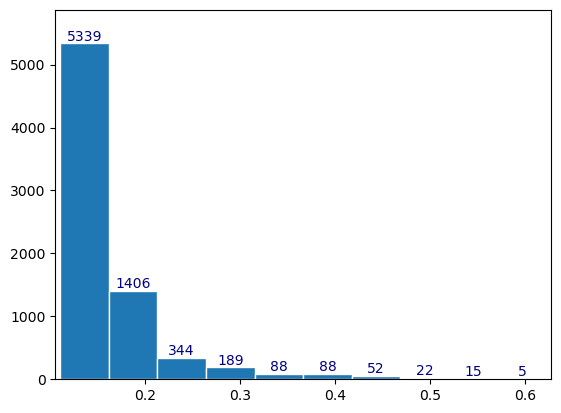

统计: 大于 threshold 724 个, 小于 6824 个
候选者 724 个, 不公平者 37 个, 比例 5.11%
--------------------------------------------------
读取缓存:  cache/2024-06-06-1--v1.csv


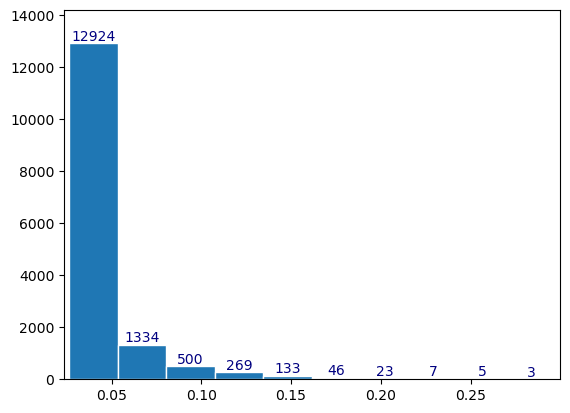

统计: 大于 threshold 48 个, 小于 15196 个
候选者 48 个, 不公平者 17 个, 比例 35.42%


In [110]:
sff = ShapFairFramework(groups, sensitive_names=sensitive_names)
female_unfair_idxs = sff.handle_group(groups[0], threshold=0.22)
male_unfair_idxs = sff.handle_group(groups[1], threshold=0.18)

In [111]:
import numpy as np
unfair_idx = np.r_[female_unfair_idxs, male_unfair_idxs]
unfair_idx, len(unfair_idx)


y_new = y_train.copy()
y_new[unfair_idx] = 1 - y_new[unfair_idx]
y_new.shape
(y_new != y_train).value_counts()

income
False    22738
True        54
Name: count, dtype: int64

In [112]:
model_new = xgboost.XGBClassifier()
model_new.fit(X_train, y_new)
y_pred = model_new.predict(X_test)

In [113]:
fm_new = FairMetric("XGBClassifier-new", y_test, y_pred, sensitive_features=sensitive_features)
fm_new.metrics

准确度(1)      0.871123
精确度(1)      0.777037
召回率(1)      0.647863
f1分数(1)     0.706595
AUC分数(1)    0.794654
DP差异(0)     0.190620
DP比率(1)     0.274112
EO差异(0)     0.105111
EO比率(1)     0.194471
Name: XGBClassifier-new, dtype: float64

In [114]:
fm.metrics

准确度(1)      0.870816
精确度(1)      0.779855
召回率(1)      0.641880
f1分数(1)     0.704173
AUC分数(1)    0.792403
DP差异(0)     0.186338
DP比率(1)     0.279521
EO差异(0)     0.091090
EO比率(1)     0.195470
Name: adult, dtype: float64

In [126]:
import pandas as pd

# 创建示例的 DataFrame 对象
data = {'Name': ['John', 'Emma', 'Mike'],
        'Age': ["25", "28", "30"]}
df = pd.DataFrame(data)

# 定义一个函数来处理每个元素
def add_prefix(name):
    return 'Mr. ' + name

# 使用 map() 方法将函数应用于 Name 列的每个元素
columns = ["Name", "Age"]
df[columns] = df[columns].map(add_prefix)

# 输出修改后的 DataFrame
print(df)

       Name     Age
0  Mr. John  Mr. 25
1  Mr. Emma  Mr. 28
2  Mr. Mike  Mr. 30
